# Understanding Transformers Through Exploration and Visualization

## Introduction

Transformers have revolutionized natural language processing since their introduction in "Attention is All You Need" (Vaswani et al., 2017). In this notebook, we'll explore and visualize what happens inside pre-trained transformer models, specifically GPT-2.

Think of this as performing an "MRI scan" on a transformer's brain while it processes text. We'll extract attention patterns, watch hidden representations evolve, and discover how different components specialize in different tasks. You'll gain an intuitive understanding of how transformers work by examining them in action.

## Learning Objectives

By the end of this notebook, you will be able to:

1. **Extract and visualize attention weights** from any pre-trained transformer model
2. **Identify attention head specialization** - understand how different heads focus on different linguistic patterns
3. **Track hidden state evolution** - see how word representations change as they flow through transformer layers
4. **Understand causal masking** in autoregressive models like GPT-2
5. **Interpret attention patterns** to understand model predictions
6. **Use visualization tools** like BertViz and custom heatmaps for model analysis
7. **Recognize common attention patterns** (positional, syntactic, semantic)

## Transformer Architecture Overview

Before diving into code, let's visualize the transformer architecture. The original transformer consists of an encoder-decoder structure, though models like GPT-2 use only the decoder part.

![Transformer Architecture](https://jalammar.github.io/images/t/transformer_resideual_layer_norm_3.png)

**Key Components:**
- **Self-Attention Mechanism**: Allows each token to attend to all other tokens in the sequence
- **Multi-Head Attention**: Multiple attention mechanisms running in parallel, each learning different patterns
- **Feed-Forward Networks**: Process each position independently after attention
- **Layer Normalization & Residual Connections**: Stabilize training and enable deep networks

![Attention Mechanism](https://jalammar.github.io/images/t/self-attention-output.png)

The self-attention mechanism computes three vectors for each token:
- **Query (Q)**: "What am I looking for?"
- **Key (K)**: "What do I contain?"
- **Value (V)**: "What information do I pass forward?"

## Setup and Installation


In [163]:
# Install required packages (run this cell once)
# Uncomment the lines below if running in a fresh environment
!pip install transformers torch matplotlib seaborn numpy ipywidgets plotly scikit-learn bertviz

# Import all necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# HuggingFace imports
from transformers import (
    AutoModel, 
    AutoTokenizer, 
    GPT2Model, 
    GPT2Tokenizer,
    BertModel,
    BertTokenizer
)

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Check if CUDA is available (not required, but faster if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Using device: cpu
PyTorch version: 2.2.2


### GPT-2 Architecture Visualization

GPT-2 uses a **decoder-only transformer architecture**. Here's a detailed visualization:

![GPT-2 Decoder-Only Architecture](https://jalammar.github.io/images/gpt2/gpt2-sizes-hyperparameters-3.png)

**Key Components of Each Transformer Block:**

![GPT-2 Transformer Block](https://jalammar.github.io/images/gpt2/gpt2-transformer-block-vectors-2.png)

1. **Masked Multi-Head Self-Attention**: Allows each token to attend to previous tokens only (causal masking)
2. **Layer Normalization**: Stabilizes training
3. **Feed-Forward Network**: Processes each position independently
4. **Residual Connections**: Enable deep networks by allowing gradients to flow

**How GPT-2 Processes Text:**

![GPT-2 Processing Flow](https://jalammar.github.io/images/xlnet/gpt-2-autoregression-2.gif)

The model processes tokens sequentially, with each layer building richer representations. The final layer's output is projected to vocabulary space to predict the next token.


## Section 1: Loading a Pre-trained Transformer

Let's start by loading GPT-2, a decoder-only transformer model. GPT-2 uses **causal self-attention**, meaning each token can only attend to previous tokens (no peeking at the future!).

The key insight: When we set `output_attentions=True`, the model returns attention weights for every head in every layer.

In [164]:
# Load GPT-2 model and tokenizer
# We use the smallest version (124M parameters) for faster computation
print("Loading GPT-2 model...")
model_name = "gpt2"  # You can also try "distilgpt2" for an even smaller model

# Initialize tokenizer - this converts text to token IDs
# Tokenizers break text into subword units (BPE tokens), which allows models
# to handle rare words and maintain a manageable vocabulary size
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 doesn't have a pad token by default

# Load model with attention output enabled
# By setting output_attentions=True and output_hidden_states=True, we can inspect
# the internal workings of the transformer at every layer. This is crucial for
# understanding what the model learns and how information flows.
model = GPT2Model.from_pretrained(
    model_name,
    output_attentions=True,    # This is crucial! Returns attention weights
    output_hidden_states=True   # Also return hidden states at each layer
).to(device)

# Move to evaluation mode (no dropout)
model.eval()

print(f"Model loaded! Architecture details:")
print(f"- Number of layers: {model.config.n_layer}")
print(f"- Number of attention heads per layer: {model.config.n_head}")
print(f"- Hidden dimension: {model.config.n_embd}")
print(f"- Vocabulary size: {model.config.vocab_size}")

Loading GPT-2 model...
Model loaded! Architecture details:
- Number of layers: 12
- Number of attention heads per layer: 12
- Hidden dimension: 768
- Vocabulary size: 50257


### Understanding Model Outputs

When we pass text through the model, we get three key outputs:
1. **Last hidden state**: Final layer representations (what we'd use for downstream tasks)
2. **Attention weights**: How much each token attended to other tokens (our main focus)
3. **Hidden states**: Token representations at each layer

In [165]:
# Let's process a simple sentence and examine the outputs
text = "The cat sat on the mat"
print(f"Input text: '{text}'")

# Tokenize the text
# Tokenization is a multi-step process:
# 1. Text -> Tokens (subword units like "The", "cat", "sat")
# 2. Tokens -> Token IDs (integers that index into the vocabulary)
# This allows the model to work with numerical representations
tokens = tokenizer.tokenize(text)
input_ids = tokenizer.encode(text, return_tensors="pt").to(device)

print(f"\nTokenization:")
print(f"Tokens: {tokens}")
print(f"Token IDs: {input_ids[0].tolist()}")

# Forward pass through the model
# torch.no_grad() disables gradient computation, saving memory and computation
# time during inference (we're not training, just analyzing)
with torch.no_grad():  # No gradient computation needed for inference
    outputs = model(input_ids)

# Extract the three main outputs
# Transformer outputs contain multiple useful components:
# 1. last_hidden_state: Final contextualized representations for each token
# 2. attentions: Attention weights showing which tokens attend to which
# 3. hidden_states: Intermediate representations at each layer
last_hidden_states = outputs.last_hidden_state  # Shape: (batch_size, sequence_length, hidden_dim)
attention_weights = outputs.attentions          # Tuple of tensors, one per layer
all_hidden_states = outputs.hidden_states       # Tuple of tensors, one per layer + embedding

print(f"\nOutput shapes:")
print(f"Last hidden states: {last_hidden_states.shape}")
print(f"Number of attention layers: {len(attention_weights)}")
print(f"Attention shape per layer: {attention_weights[0].shape}")  # (batch, heads, seq_len, seq_len)
print(f"Number of hidden state layers: {len(all_hidden_states)}")

Input text: 'The cat sat on the mat'

Tokenization:
Tokens: ['The', 'Ġcat', 'Ġsat', 'Ġon', 'Ġthe', 'Ġmat']
Token IDs: [464, 3797, 3332, 319, 262, 2603]

Output shapes:
Last hidden states: torch.Size([1, 6, 768])
Number of attention layers: 12
Attention shape per layer: torch.Size([1, 12, 6, 6])
Number of hidden state layers: 13


**Key Insight**: Each attention weight tensor has shape `(batch_size, num_heads, seq_length, seq_length)`. The last two dimensions form an attention matrix where element `[i, j]` represents how much token `i` attends to token `j`.

## Section 2: Visualizing Attention Patterns

Now let's visualize what the model is "looking at" when processing text. We'll create heatmaps showing attention weights between tokens.

The attention mechanism can be thought of as asking: "When processing each word, which other words should I pay attention to?"


Debug info:
Attention matrix shape: (6, 6)
Number of tokens: 6
Tokens: ['The', 'Ġcat', 'Ġsat', 'Ġon', 'Ġthe', 'Ġmat']


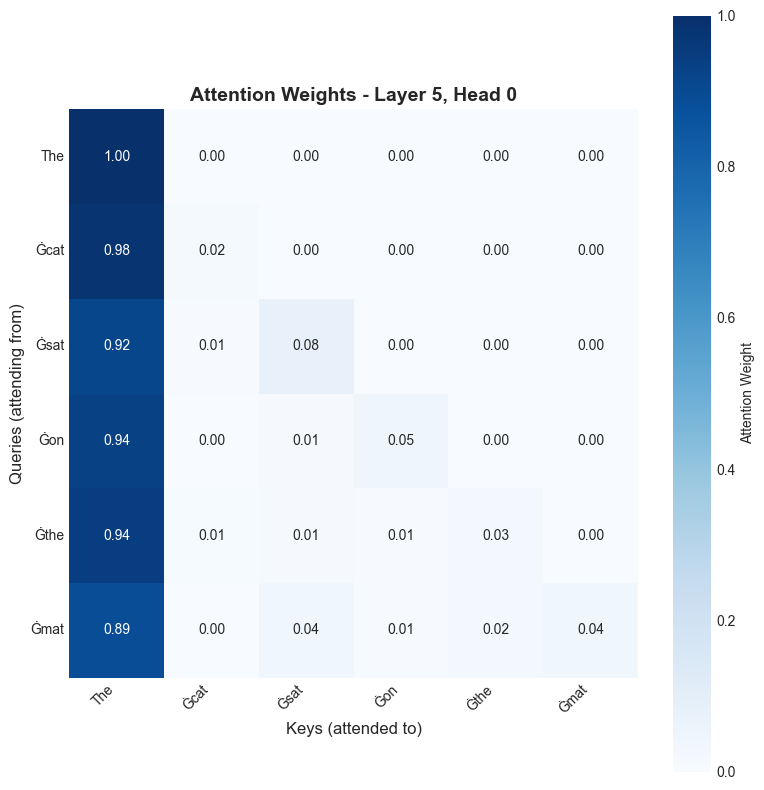

In [166]:
def visualize_attention(attention_matrix, tokens, layer_num, head_num, figsize=None):
    """
    Visualize attention weights as a heatmap.
    
    Attention matrices are square (seq_len × seq_len) where:
    - Rows represent "query" tokens (tokens that are attending)
    - Columns represent "key" tokens (tokens being attended to)
    - Each cell [i,j] shows how much token i attends to token j
    - Values sum to 1.0 across each row (softmax normalization)
    
    Args:
        attention_matrix: 2D numpy array of attention weights
        tokens: List of token strings
        layer_num: Which layer this attention is from
        head_num: Which attention head this is from
        figsize: Figure size for matplotlib (auto-calculated if None)
    """
    # Auto-calculate figure size based on number of tokens
    if figsize is None:
        seq_len = len(tokens)
        # Scale figure size with sequence length (min 8, add 0.5 per token beyond 6)
        size = max(8, 6 + (seq_len - 6) * 0.5)
        figsize = (size, size)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap using seaborn for prettier visualization
    sns.heatmap(
        attention_matrix,
        annot=True,           # Show numbers in cells
        fmt='.2f',           # Format numbers to 2 decimal places
        cmap='Blues',        # Color scheme
        cbar_kws={'label': 'Attention Weight'},
        xticklabels=tokens,
        yticklabels=tokens,
        vmin=0,
        vmax=1,
        ax=ax,
        square=True          # Force square cells for better readability
    )
    
    # Labels and title
    ax.set_xlabel('Keys (attended to)', fontsize=12)
    ax.set_ylabel('Queries (attending from)', fontsize=12)
    ax.set_title(f'Attention Weights - Layer {layer_num}, Head {head_num}', fontsize=14, fontweight='bold')
    
    # Rotate x-axis labels for readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    return fig

# Visualize attention from a specific layer and head
layer_to_viz = 5  # Middle layer often shows interesting patterns
head_to_viz = 0   # First head

# Extract attention weights for this specific layer and head
# Remove batch dimension [0] and move to CPU for visualization
attention_matrix = attention_weights[layer_to_viz][0, head_to_viz].cpu().numpy()

# Debug: Print shapes to ensure they match
print(f"\nDebug info:")
print(f"Attention matrix shape: {attention_matrix.shape}")
print(f"Number of tokens: {len(tokens)}")
print(f"Tokens: {tokens}")

# Verify dimensions match
assert attention_matrix.shape[0] == len(tokens), \
    f"Mismatch! Attention has {attention_matrix.shape[0]} rows but {len(tokens)} tokens"
assert attention_matrix.shape[1] == len(tokens), \
    f"Mismatch! Attention has {attention_matrix.shape[1]} cols but {len(tokens)} tokens"

# Create visualization
fig = visualize_attention(attention_matrix, tokens, layer_to_viz, head_to_viz)
plt.show()

**What are we seeing?**
- Each row shows where that token is "looking" when being processed
- Darker blue indicates stronger attention
- Notice the **triangular pattern** - this is **causal masking** in action! Each token can only attend to previous tokens and itself
- The diagonal often has strong values (self-attention)
- **Why are later tokens (rows) blank?** This is GPT-2's autoregressive nature:
  - Token 1 ("The") can only attend to itself → 1 attention score
  - Token 2 ("cat") can attend to "The" and itself → 2 attention scores  
  - Token 6 ("mat") can attend to all 6 previous tokens → 6 attention scores
  - Future tokens haven't been processed yet in this forward pass
- The attention weights always sum to 1.0 across each row (softmax normalization)

## Section 3: Discovering Attention Head Specialization

One fascinating aspect of transformers is that different attention heads learn to focus on different types of relationships. Let's explore multiple heads to see their specialization.

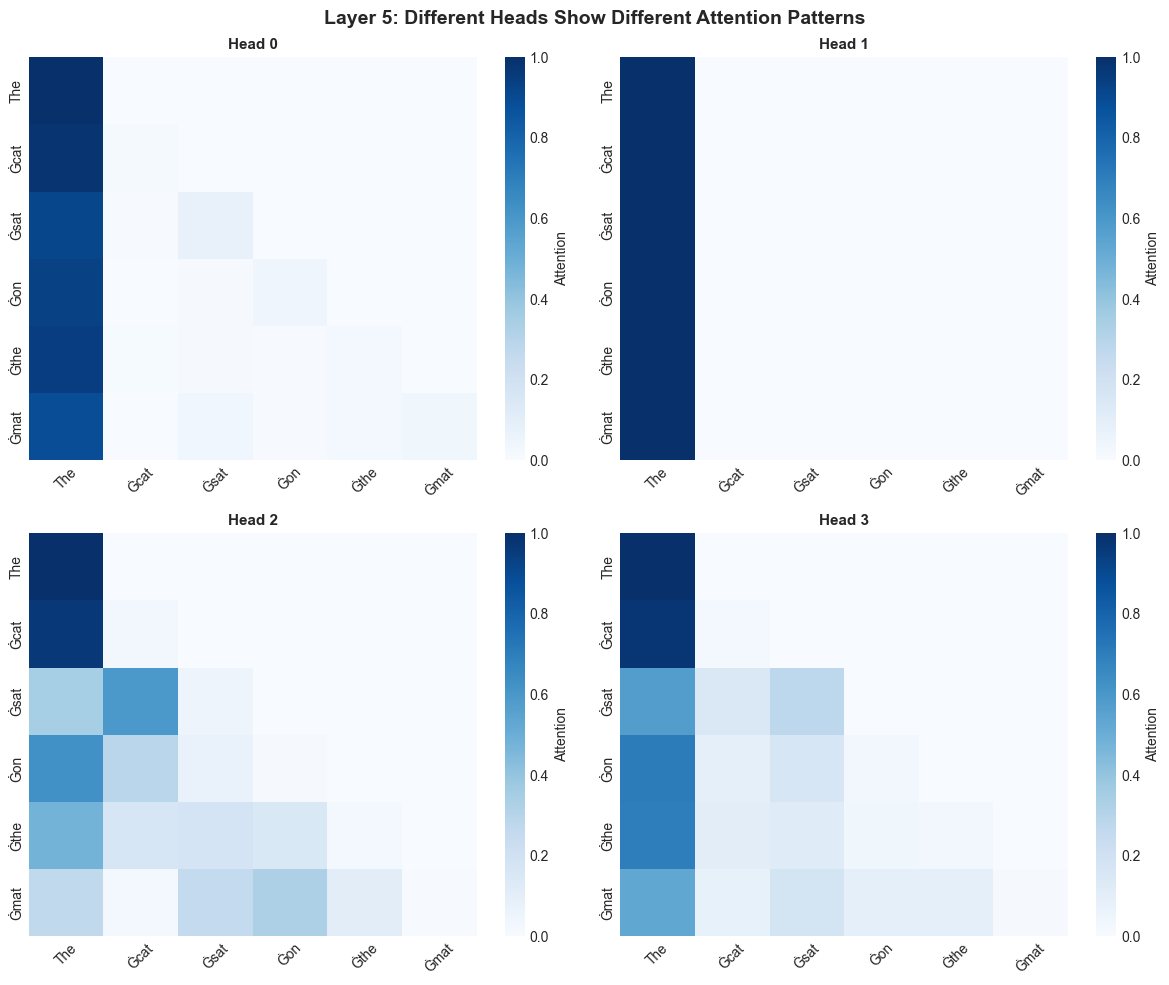

In [167]:
def plot_attention_heads(attention_weights, tokens, layer_num, num_heads_to_show=4):
    """
    Plot multiple attention heads from the same layer in a grid.
    
    Multi-head attention is a key innovation in transformers. Each head learns
    to focus on different types of relationships:
    - Some heads capture positional patterns (adjacent words)
    - Some heads capture syntactic patterns (subject-verb relationships)
    - Some heads capture semantic patterns (related concepts)
    
    This diversity allows the model to process multiple types of information in parallel.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for head_idx in range(min(num_heads_to_show, attention_weights[layer_num].shape[1])):
        ax = axes[head_idx]
        
        # Extract attention for this head
        attn_matrix = attention_weights[layer_num][0, head_idx].cpu().numpy()
        
        # Create heatmap
        sns.heatmap(
            attn_matrix,
            cmap='Blues',
            ax=ax,
            cbar=True,
            xticklabels=tokens,
            yticklabels=tokens,
            vmin=0,
            vmax=1,
            cbar_kws={'label': 'Attention'}
        )
        
        ax.set_title(f'Head {head_idx}', fontsize=11, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='x', rotation=45)
    
    fig.suptitle(f'Layer {layer_num}: Different Heads Show Different Attention Patterns', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

# Visualize 4 different heads from the same layer
fig = plot_attention_heads(attention_weights, tokens, layer_num=5)
plt.show()

**Observation**: Different heads often specialize in different types of relationships:
- Some heads focus on adjacent tokens (local context)
- Some heads attend to the beginning of the sequence
- Some heads show more distributed attention
- Later layers often show more semantic relationships

Testing with: 'The quick brown fox jumps over the lazy dog'


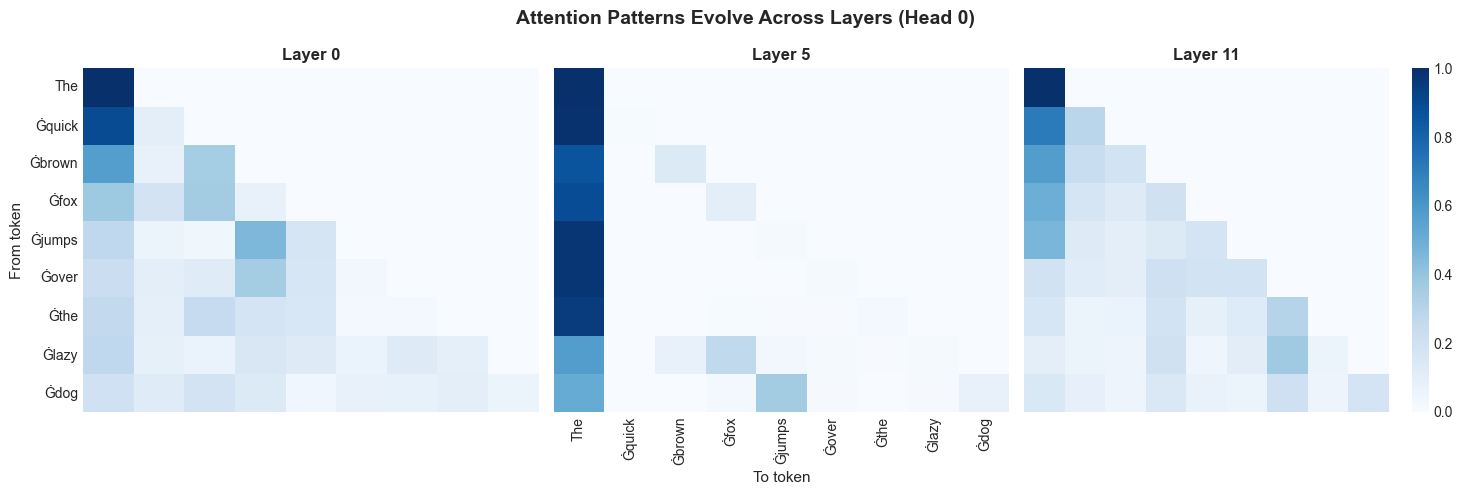

In [168]:
# Let's test this with a more complex sentence to see clearer patterns
complex_text = "The quick brown fox jumps over the lazy dog"
print(f"Testing with: '{complex_text}'")

# Process the new text
complex_tokens = tokenizer.tokenize(complex_text)
complex_input_ids = tokenizer.encode(complex_text, return_tensors="pt").to(device)

with torch.no_grad():
    complex_outputs = model(complex_input_ids)
    
complex_attention = complex_outputs.attentions

# Visualize early vs late layer attention patterns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

layers_to_compare = [0, 5, 11]  # Early, middle, late layers
head_idx = 0  # Same head across layers

for i, layer_idx in enumerate(layers_to_compare):
    attn = complex_attention[layer_idx][0, head_idx].cpu().numpy()
    
    sns.heatmap(
        attn,
        cmap='Blues',
        ax=axes[i],
        xticklabels=complex_tokens if i == 1 else False,
        yticklabels=complex_tokens if i == 0 else False,
        vmin=0,
        vmax=1,
        cbar=i == 2  # Only show colorbar on last plot
    )
    
    axes[i].set_title(f'Layer {layer_idx}', fontsize=12, fontweight='bold')
    
    if i == 0:
        axes[i].set_ylabel('From token', fontsize=11)
    if i == 1:
        axes[i].set_xlabel('To token', fontsize=11)

fig.suptitle('Attention Patterns Evolve Across Layers (Head 0)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Key Insight**: 
- **Early layers** (Layer 0): Often show more positional patterns, attending to nearby tokens
- **Middle layers** (Layer 5): Begin showing syntactic relationships
- **Late layers** (Layer 11): Focus more on semantic relationships and task-specific patterns

## Section 4: Tracking Hidden State Evolution

As tokens pass through the transformer layers, their representations evolve from simple embeddings to rich, contextualized representations. Let's visualize this journey.

Mathematical notation: For a token at position $i$, its hidden state at layer $l$ is denoted as $h_i^{(l)}$.

In [169]:
def extract_token_representations(hidden_states, token_idx):
    """
    Extract the representation of a specific token across all layers.
    
    Token representations evolve through the network:
    - Layer 0 (embedding): Static, context-independent representation
    - Early layers: Incorporate local context (nearby words)
    - Middle layers: Capture syntactic relationships
    - Late layers: Encode semantic meaning and task-specific features
    
    Tracking this evolution helps us understand how transformers build understanding.
    
    Args:
        hidden_states: Tuple of hidden states from all layers
        token_idx: Which token position to track
    
    Returns:
        Tensor of shape (num_layers, hidden_dim)
    """
    # Stack representations from all layers for the specified token
    token_journey = torch.stack([
        layer_output[0, token_idx, :]  # [batch, seq, hidden] -> extract one token
        for layer_output in hidden_states
    ])
    
    return token_journey

In [170]:
def analyze_word_evolution(target_word, target_text, model, tokenizer, device):
    """
    Complete analysis pipeline for tracking a word's evolution through transformer layers.
    
    This function encapsulates the entire workflow:
    1. Tokenize the input text
    2. Find all positions where the target word appears
    3. Run the model to get hidden states
    4. Extract and analyze token representations
    5. Print diagnostic information
    
    Args:
        target_word: The word to track (e.g., "apple")
        target_text: The sentence containing the word (e.g., "I eat an apple in the apple store")
        model: The transformer model
        tokenizer: The tokenizer
        device: The device (CPU or GPU)
    
    Returns:
        Dictionary containing:
        - tokens: List of all tokens
        - target_positions: Positions where target word appears
        - hidden_states: Model hidden states
        - outputs: Full model outputs
    """
    print(f"\n{'='*60}")
    print(f"Analyzing word: '{target_word}'")
    print(f"In text: '{target_text}'")
    print(f"{'='*60}\n")
    
    # Tokenize and find the position of target word tokens
    tokens = tokenizer.tokenize(target_text)
    input_ids = tokenizer.encode(target_text, return_tensors="pt").to(device)
    
    # Find all positions where the target word appears
    # Note: We use case-insensitive matching and check if target_word is in the token
    target_positions = [i for i, token in enumerate(tokens) if target_word.lower() in token.lower()]
    
    print(f"Tokens: {tokens}")
    print(f"\n'{target_word}' appears at positions: {target_positions}")
    
    if not target_positions:
        print(f"\n⚠️  Warning: '{target_word}' not found in the tokenized text!")
        print(f"This might happen if the word is split into multiple subword tokens.")
        print(f"Try searching for a substring of the word.")
        return None
    
    # Get model outputs with hidden states
    print(f"\nRunning model inference...")
    with torch.no_grad():
        outputs = model(input_ids)
    
    # Extract representations for each occurrence
    print(f"\nExtracting hidden state evolution for {len(target_positions)} occurrence(s)...")
    for idx, pos in enumerate(target_positions):
        evolution = extract_token_representations(
            outputs.hidden_states, 
            pos
        ).cpu().numpy()
        
        print(f"  Occurrence {idx+1} at position {pos} ('{tokens[pos]}'):")
        print(f"    Shape: {evolution.shape}")
        print(f"    ({evolution.shape[0]} layers × {evolution.shape[1]} dimensions)")
    
    return {
        'tokens': tokens,
        'target_positions': target_positions,
        'hidden_states': outputs.hidden_states,
        'outputs': outputs
    }

In [185]:
# =============================================================================
# CONFIGURATION: Specify your target word and text here
# =============================================================================
target_word = "learning"
target_text = "I am learning machine learning"

# Run the complete analysis
analysis_results = analyze_word_evolution(target_word, target_text, model, tokenizer, device)


Analyzing word: 'learning'
In text: 'I am learning machine learning'

Tokens: ['I', 'Ġam', 'Ġlearning', 'Ġmachine', 'Ġlearning']

'learning' appears at positions: [2, 4]

Running model inference...

Extracting hidden state evolution for 2 occurrence(s)...
  Occurrence 1 at position 2 ('Ġlearning'):
    Shape: (13, 768)
    (13 layers × 768 dimensions)
  Occurrence 2 at position 4 ('Ġlearning'):
    Shape: (13, 768)
    (13 layers × 768 dimensions)


### Visualizing Representation Changes with PCA

Since hidden states are high-dimensional (768 dimensions for GPT-2), we'll use PCA (Principal Component Analysis) to project them to 2D for visualization.

In [186]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def visualize_token_evolution(hidden_states, token_positions, tokens, token_name="token"):
    """
    Visualize how token representations evolve through layers using PCA.
    
    We use PCA (Principal Component Analysis) for dimensionality reduction:
    - Transformer hidden states are high-dimensional (768D for GPT-2)
    - PCA projects them to 2D while preserving maximum variance
    - This allows us to visualize the "journey" of a token through the network
    - The path shows how context progressively shapes the representation
    """
    # Extract representations for specified tokens
    all_evolutions = []
    labels = []
    
    for pos in token_positions:
        evolution = extract_token_representations(hidden_states, pos).cpu().numpy()
        all_evolutions.append(evolution)
        # Create labels for each layer
        labels.extend([f"Layer {i}" for i in range(len(evolution))])
    
    # Stack all evolutions
    all_evolutions = np.vstack(all_evolutions)
    
    # Reduce dimensionality with PCA
    pca = PCA(n_components=2)
    evolution_2d = pca.fit_transform(all_evolutions)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot each token's journey
    colors = plt.cm.viridis(np.linspace(0, 1, len(token_positions)))
    
    for i, pos in enumerate(token_positions):
        start_idx = i * 13  # 13 layers per token
        end_idx = start_idx + 13
        
        token_trajectory = evolution_2d[start_idx:end_idx]
        
        # Plot the path
        ax.plot(token_trajectory[:, 0], 
                token_trajectory[:, 1], 
                'o-', 
                color=colors[i],
                markersize=8,
                linewidth=2,
                alpha=0.7,
                label=f"'{tokens[pos]}' (pos {pos})")
        
        # Annotate start and end
        ax.annotate('START', 
                   xy=token_trajectory[0], 
                   xytext=(5, 5),
                   textcoords='offset points',
                   fontsize=8,
                   color=colors[i])
        ax.annotate('END', 
                   xy=token_trajectory[-1], 
                   xytext=(5, 5),
                   textcoords='offset points',
                   fontsize=8,
                   fontweight='bold',
                   color=colors[i])
    
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
    ax.set_title(f'How "{token_name}" Representations Evolve Through Transformer Layers', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    
    plt.tight_layout()
    return fig

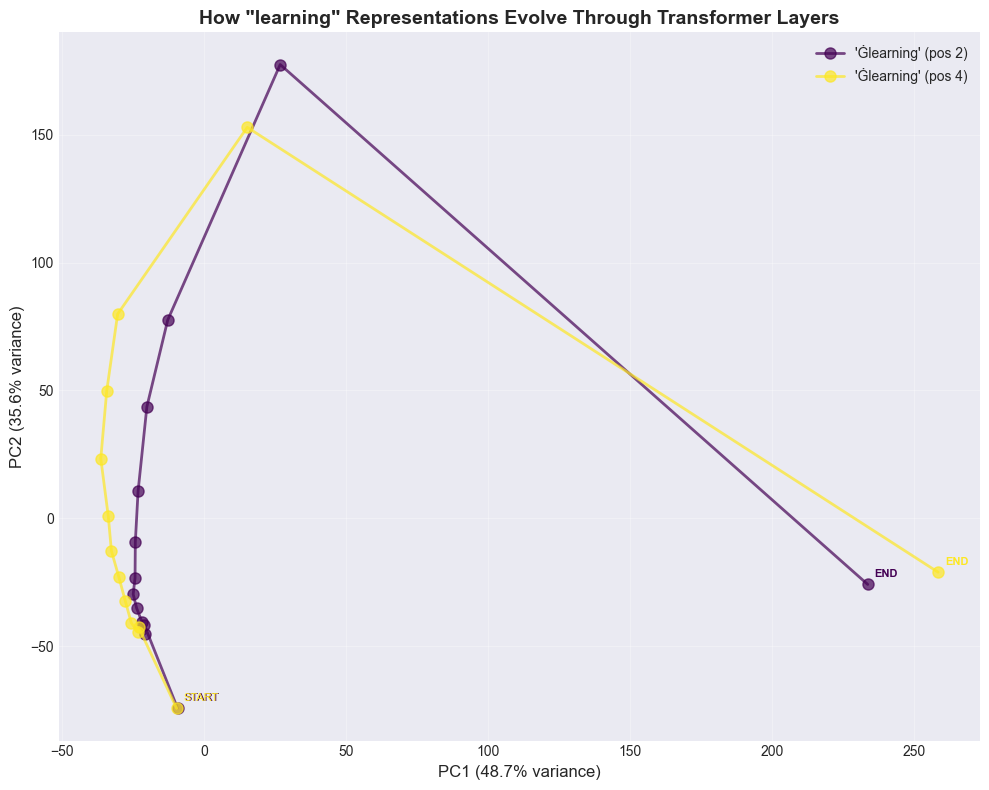

In [187]:
# Automatically visualize the evolution if target word was found
fig = visualize_token_evolution(
        analysis_results['hidden_states'], 
        analysis_results['target_positions'], 
        analysis_results['tokens'],
        token_name=target_word
    )
plt.show()

**What this tells us**:
- Tokens start from their initial embeddings (START)
- As they pass through layers, their representations move in the latent space
- The journey shows how context gets incorporated progressively
- Different occurrences of the same word can end up in different places based on context

## Section 5: Understanding Causal Masking

GPT-2 is an **autoregressive** model, meaning it generates text left-to-right and can only attend to previous tokens. This is enforced through **causal masking**.

The attention score between tokens $i$ and $j$ is computed as:
$$\text{Attention}(Q_i, K_j) = \begin{cases} 
\frac{Q_i \cdot K_j}{\sqrt{d_k}} & \text{if } j \leq i \\
-\infty & \text{if } j > i
\end{cases}$$

After softmax, $-\infty$ becomes 0, ensuring no information flows from future tokens.

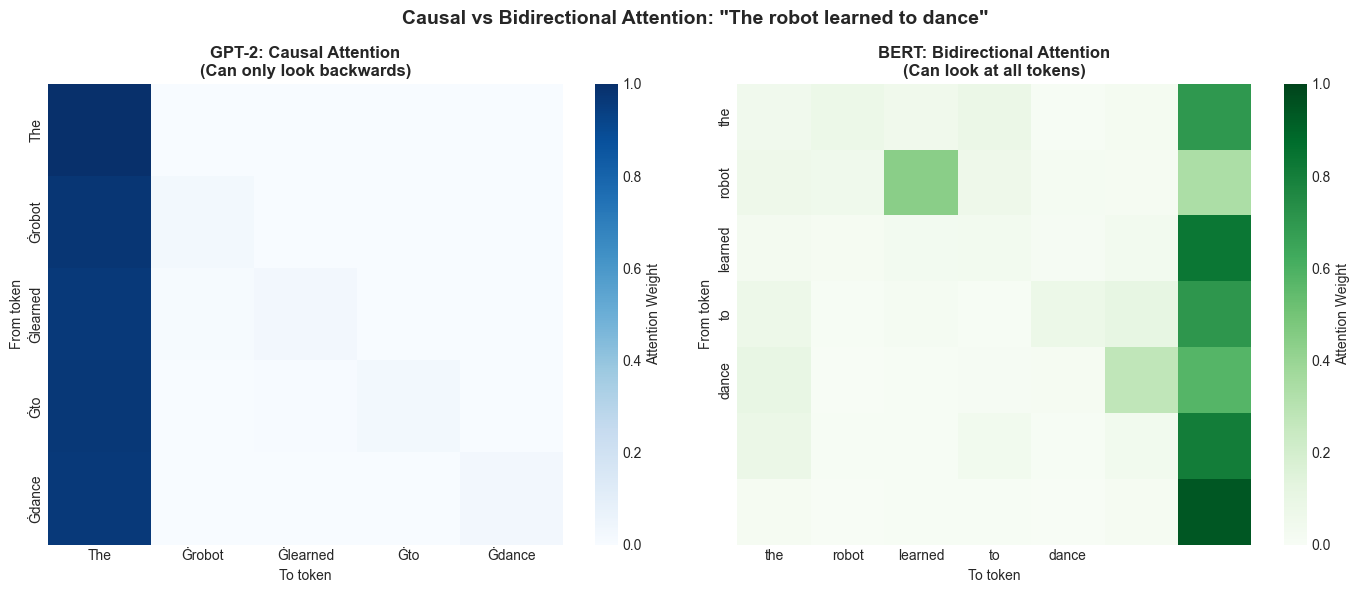

In [174]:
def visualize_causal_vs_bidirectional():
    """
    Compare GPT-2's causal attention with BERT's bidirectional attention.
    
    This demonstrates a fundamental architectural difference:
    
    GPT-2 (Causal/Autoregressive): Each token can only attend to previous tokens
      * Enables left-to-right text generation
      * Creates triangular attention patterns (causal masking)
      * Used for: text generation, completion, dialogue
    
    BERT (Bidirectional): Each token can attend to all tokens in both directions
      * Enables better understanding of context
      * Creates full attention matrices
      * Used for: classification, question answering, named entity recognition
    
    The choice of attention pattern determines what tasks the model excels at.
    """
    test_sentence = "The robot learned to dance"
    
    # Process with GPT-2 (causal)
    gpt2_tokens = tokenizer.tokenize(test_sentence)
    gpt2_ids = tokenizer.encode(test_sentence, return_tensors="pt").to(device)
    
    with torch.no_grad():
        gpt2_outputs = model(gpt2_ids)
    
    # Process with BERT (bidirectional) for comparison
    # Note: BERT uses a different tokenization scheme (WordPiece) and adds
    # special tokens [CLS] at the start and [SEP] at the end.
    # This will download BERT if not already cached
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True).to(device)
    
    bert_ids = bert_tokenizer.encode(test_sentence, return_tensors="pt").to(device)
    bert_tokens = bert_tokenizer.tokenize(test_sentence)
    
    with torch.no_grad():
        bert_outputs = bert_model(bert_ids)
    
    # Create side-by-side comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # GPT-2 attention (causal)
    gpt2_attn = gpt2_outputs.attentions[5][0, 0].cpu().numpy()  # Layer 5, Head 0
    sns.heatmap(
        gpt2_attn,
        cmap='Blues',
        ax=axes[0],
        xticklabels=gpt2_tokens,
        yticklabels=gpt2_tokens,
        cbar_kws={'label': 'Attention Weight'},
        vmin=0,
        vmax=1
    )
    axes[0].set_title('GPT-2: Causal Attention\n(Can only look backwards)', 
                      fontsize=12, fontweight='bold')
    axes[0].set_xlabel('To token')
    axes[0].set_ylabel('From token')
    
    # BERT attention (bidirectional)
    bert_attn = bert_outputs.attentions[5][0, 0].cpu().numpy()  # Layer 5, Head 0
    sns.heatmap(
        bert_attn,
        cmap='Greens',
        ax=axes[1],
        xticklabels=bert_tokens,
        yticklabels=bert_tokens,
        cbar_kws={'label': 'Attention Weight'},
        vmin=0,
        vmax=1
    )
    axes[1].set_title('BERT: Bidirectional Attention\n(Can look at all tokens)', 
                      fontsize=12, fontweight='bold')
    axes[1].set_xlabel('To token')
    axes[1].set_ylabel('From token')
    
    fig.suptitle(f'Causal vs Bidirectional Attention: "{test_sentence}"', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

# Compare attention patterns
fig = visualize_causal_vs_bidirectional()
plt.show()

**Key Differences**:
- **GPT-2 (Causal)**: Shows a triangular pattern - tokens can only attend to previous tokens
- **BERT (Bidirectional)**: Full attention matrix - any token can attend to any other token
- This fundamental difference makes GPT-2 suitable for generation and BERT for understanding

## Section 6: Advanced Visualization with BertViz

BertViz provides professional-grade interactive visualizations for attention analysis. Let's explore its capabilities.


In [189]:
# Import BertViz for advanced visualizations
try:
    from bertviz import model_view, head_view
    bertviz_available = True
except ImportError:
    print("BertViz not installed. Install with: pip install bertviz")
    print("Continuing with manual visualizations...")
    bertviz_available = False

if bertviz_available:
    # Prepare inputs for BertViz
    sentence_a = "The cat sat on the mat"
    sentence_b = "because it was tired"
    
    inputs = tokenizer.encode_plus(
        sentence_a, 
        sentence_b,
        return_tensors='pt',
        add_special_tokens=True
    ).to(device)
    
    input_ids = inputs['input_ids']
    
    # Get attention weights
    with torch.no_grad():
        outputs = model(input_ids)
    
    attention = outputs.attentions  # Tuple of length num_layers
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    print("BertViz provides two main visualization types:")
    print("1. Head View - Shows attention from all heads in a single layer")
    print("2. Model View - Shows attention across all layers and heads")
    print("\nNote: These create interactive HTML visualizations best viewed in Jupyter")
    
    # Create head view (this would be interactive in Jupyter)
    # Uncomment the following lines when running in Jupyter:
    head_view(attention, tokens, layer=5)  # View layer 5
    
    # Create model view (this would be interactive in Jupyter)
    # Uncomment the following line when running in Jupyter:
    model_view(attention, tokens)
    
else:
    print("Skipping BertViz visualizations...")

BertViz provides two main visualization types:
1. Head View - Shows attention from all heads in a single layer
2. Model View - Shows attention across all layers and heads

Note: These create interactive HTML visualizations best viewed in Jupyter


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusion

Through this exploration, we've peered inside the "black box" of transformer models without writing a single training loop or implementing attention from scratch. By visualizing and analyzing pre-trained models, we've gained intuition for:

- How attention mechanisms decide what information to use
- Why different layers and heads specialize in different patterns  
- How word representations evolve from simple embeddings to rich, contextualized vectors
- The fundamental difference between causal and bidirectional attention

Now that you understand how transformers process information internally, you're ready to take the next step: **Project 2: Neural Archaeology**. In this project, you'll go deeper into the hidden layers of language models to decode how they represent concepts like safety, emotion, and truthfulness. This hands-on project will transform your understanding from "how attention works" to "what models actually learn" by applying cutting-edge interpretability techniques from AI safety research. 

### Resources

- **Papers**: "Attention is All You Need" (Vaswani et al., 2017), "What Does BERT Look At?" (Clark et al., 2019)
- **Tutorials**: Jay Alammar's "The Illustrated Transformer", Andrej Karpathy's "minGPT"
- **Tools**: HuggingFace Transformers documentation, BertViz repository

Remember: The best way to understand transformers is to experiment with them. Use this notebook as a starting point and modify it to explore your own questions!